# TIME SERIES ANALYSIS
The goal of this project is to assess and better understand the driving factors behind Google search interest for homedepot.

I used the Google Trends API to collect Google Trends data. In the next step,I have gathered data from the Google Trends API using Search Sampler package. 

Importing required tools and packages 

In [454]:
from statsmodels.tsa import stattools
from pandas.plotting import autocorrelation_plot
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as pyplot
import pandas as pd
import numpy as np
from statsmodels.tsa import seasonal
from statistics import mode

Reading the googletrends csv

In [455]:
home_dp = pd.read_csv("homedepot.googletrends.csv", parse_dates=["period"])


In [456]:
home_dp["period"] = pd.to_datetime(home_dp["period"])

Trimming timestamp from 'period' in dataframe so that only date remains

In [457]:
home_dp['period'] = home_dp['period'].dt.date 

Creating line plot of x which is defined by Period and y as value

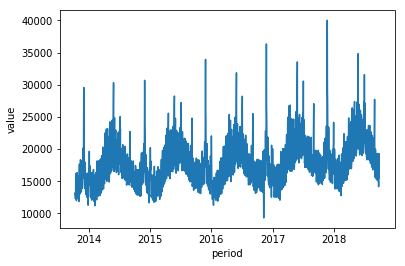

In [458]:
homedepotplot = sns.lineplot(x = "period", y = "value", data = home_dp) 


Performing adf test for stationarity

In [459]:
adf_result = stattools.adfuller(home_dp['value'])

The first value represents the value of test.
The second value defines the significance value.
The data can be considered stationary if the significance value is below 0.05. My data is stationary as it is much less than 0.05.

In [460]:
adf_result

(-4.406327321950917,
 0.00028927197740259166,
 22,
 1798,
 {'1%': -3.4339921916016345,
  '10%': -2.5676264862577503,
  '5%': -2.8631488249300574},
 31792.71589886509)

Next I am converting the data to a stationary format that is acceptable for time series modeling and compare the results with a plot.

In [461]:
home_dp['onediffvalue'] = home_dp['value'].diff(1)

The first row in onediffvalue column is NaN because there is no value above it. 

In [462]:
home_dp.head()

,Unnamed: 0,date,value,period,onediffvalue
0,0,Oct 07 2013,13131.555401,2013-10-07,NaN
1,1,Oct 08 2013,12909.450492,2013-10-08,-222.104909
2,2,Oct 09 2013,12590.684964,2013-10-09,-318.765527
3,3,Oct 10 2013,12300.446565,2013-10-10,-290.238400
4,4,Oct 11 2013,12599.330034,2013-10-11,298.883469


For plotting the column onediffvalue, we need to get rid of the NaN row. I am using i locking function to do the same.

In [463]:
adf_result = stattools.adfuller(home_dp['onediffvalue'].iloc[1:])


Checking the adf result of stationary data.
Compared to the above test, the significance value is much lesser here. 

In [464]:
adf_result

(-12.405812426072526,
 4.4552728169929937e-23,
 25,
 1794,
 {'1%': -3.4340003240943844,
  '10%': -2.567628397867784,
  '5%': -2.8631524150111547},
 31772.211547493796)

Creating line plot of x which is defined by Period and y as onediffvalue instead of value.

The is new stationary data where the mean is constant as well as variance with an exception of few.

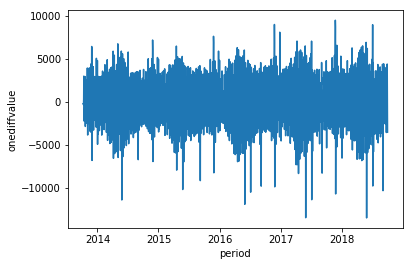

In [465]:
homedepotplot = sns.lineplot(x = "period", y = "onediffvalue", data = home_dp) 


Creating new time series analysis using value difference variable.
It can be observed that there is a huge variance in google search in the month of June every year with July in some years and December in some.

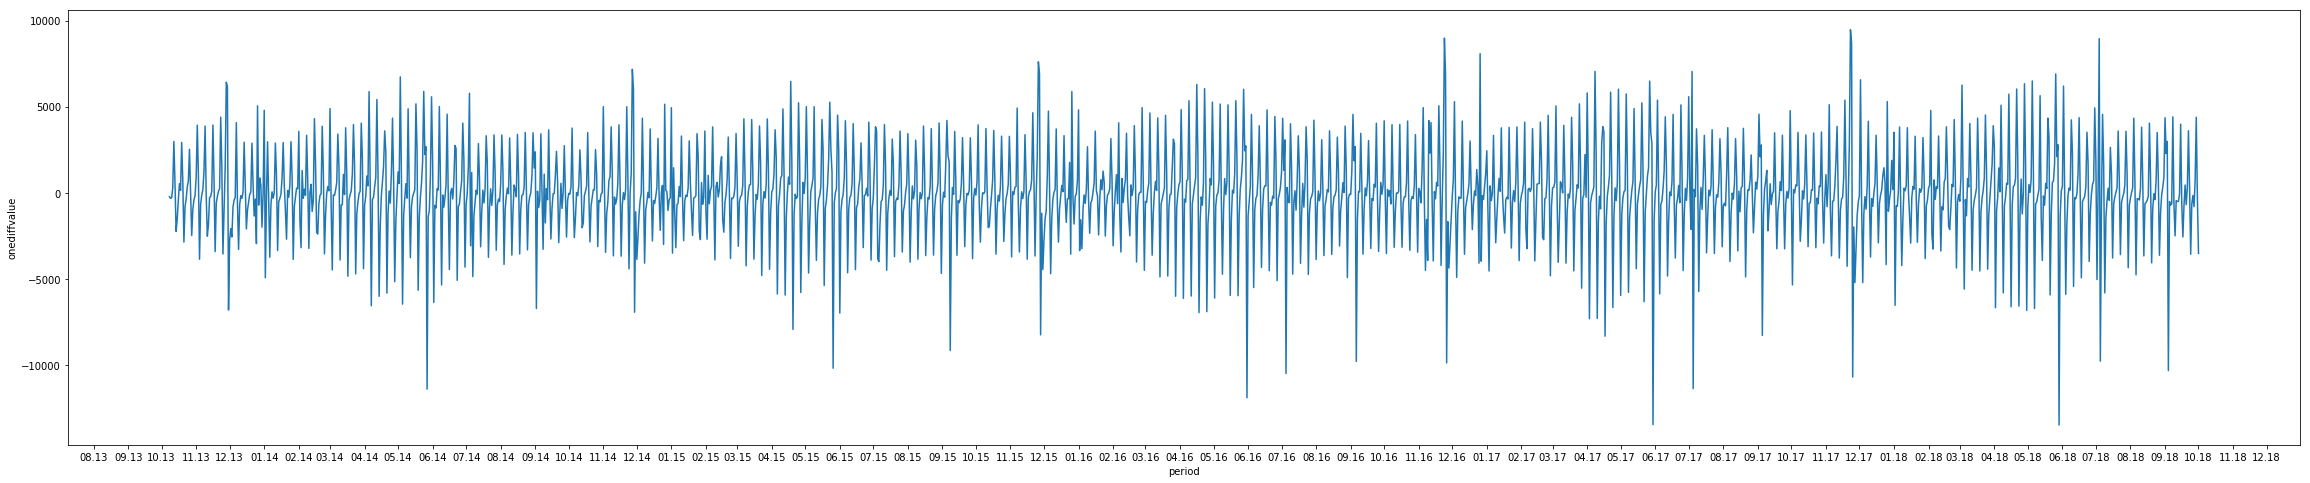

In [466]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearmonth = mdates.DateFormatter('%m.%y')

dims = (40, 8)
fig, ax = plt.subplots(figsize=dims)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)
homedepot_plot = sns.lineplot(x = "period", y = "onediffvalue", data = home_dp, ax=ax)



Here I am making the period column as index for easy analysis later. 

In [467]:
home_dp.set_index('period',inplace = True)


# Seasonality Functionality Decompose
I want to figure out what lies underneath the data.
I am decomposing the data by using a function from time series package: seasonal.decompose.
The decomposed model takes the time series data, tries to pick the seasonal pattern and minimises the residuals.

In [468]:
decompose_model = seasonal.seasonal_decompose(home_dp['value'].tolist(), freq = 365, model = 'additive')


In [469]:
dir(decompose_model) 

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'nobs',
 'observed',
 'plot',
 'resid',
 'seasonal',
 'trend']

Creating a tuple of subplots.
Plot 1: non-stationary time series 
Plot 2: General trend after accounting for seasonality
Plot 3: Seasonality plot
Plot 4: Residuals plot(outliers)

Q1.What is the overall trend? Is the search interest for your brand steadily growing?
Answer: After taking out seasonality, we still see a positive trend in the data. Over the years observed, it went from an average score of 16k to 19k, which means a positive gain of about 3k in google trend search. Therefore, it can be said that the data is getting better by 400-500 google search a year. 

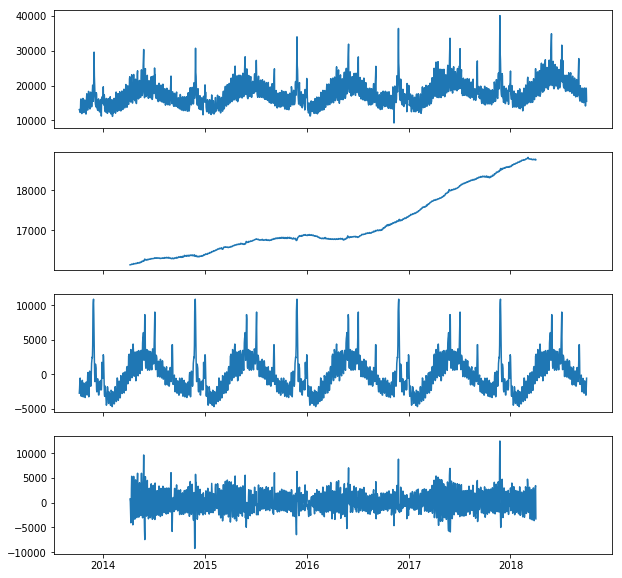

In [470]:
dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4 , figsize = dimensions, sharex = 'all')

ax1.plot(home_dp.index,home_dp['value'])
ax2.plot(home_dp.index,decompose_model.trend)
ax3.plot(home_dp.index,decompose_model.seasonal)
ax4.plot(home_dp.index,decompose_model.resid)



In the next step I want to take this seasonality model and add it to the dataframe. 
Explanation of the column: It tells us whethere it is a good or a bad day. On the day of 7th October 2013, we expect our value to be 2750.34 less than the average value.

In [471]:
home_dp['seasonal'] = decompose_model.seasonal
home_dp.head()

,Unnamed: 0,date,value,onediffvalue,seasonal
period,,,,,
2013-10-07,0,Oct 07 2013,13131.555401,NaN,-2750.349013
2013-10-08,1,Oct 08 2013,12909.450492,-222.104909,-2047.359589
2013-10-09,2,Oct 09 2013,12590.684964,-318.765527,-999.005147
2013-10-10,3,Oct 10 2013,12300.446565,-290.238400,-561.772008
2013-10-11,4,Oct 11 2013,12599.330034,298.883469,-1035.479192


Picking one year to closely observe the data.

In [472]:
startdate = pd.to_datetime("2015-01-01").date()

enddate = pd.to_datetime("2015-12-31").date()

In [473]:
oneyear = home_dp.loc[startdate : enddate]

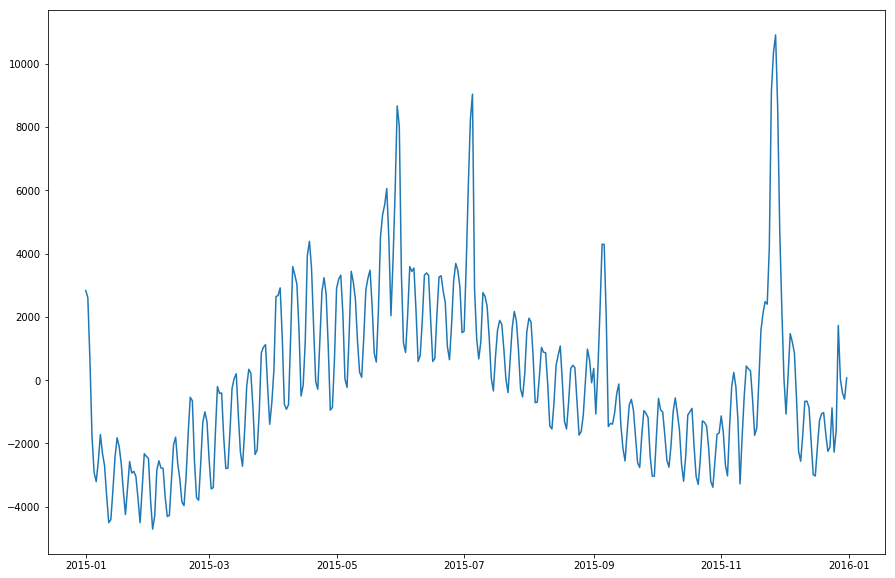

In [474]:
dimensions = (15,10)

fig, ax1 = pyplot.subplots(figsize = dimensions)

pyplot.plot(oneyear.index, oneyear.seasonal)

Creating plots only for the months with spikes to check the specific dates.

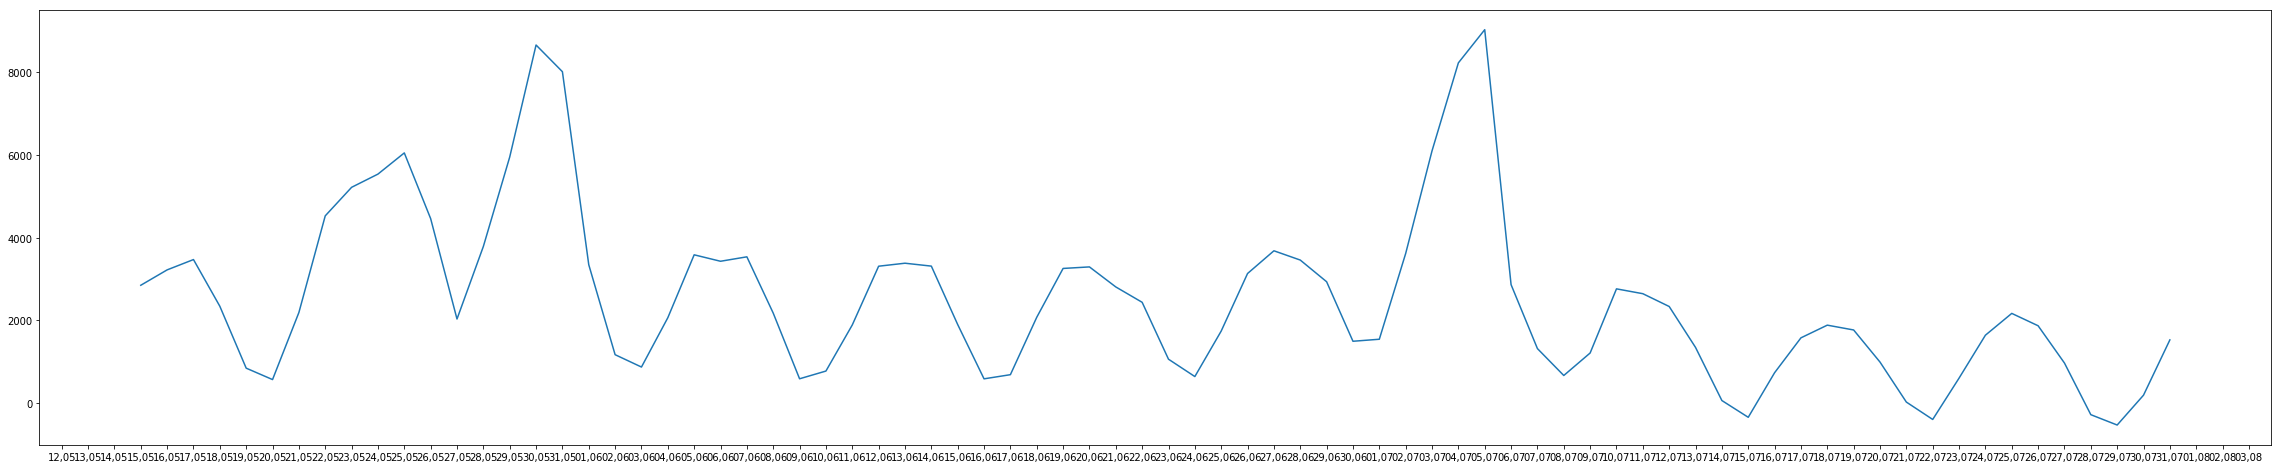

In [475]:
startdate = pd.to_datetime("2015-05-15").date()

enddate = pd.to_datetime("2015-07-31").date()

May_to_July = home_dp.loc[startdate : enddate]

dimensions = (40,8)
fig, ax = pyplot.subplots(figsize = dimensions)
months = mdates.MonthLocator()
days = mdates.DayLocator()
daymonth = mdates.DateFormatter('%d,%m')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daymonth)

ax.plot(May_to_July.index, May_to_July.seasonal)



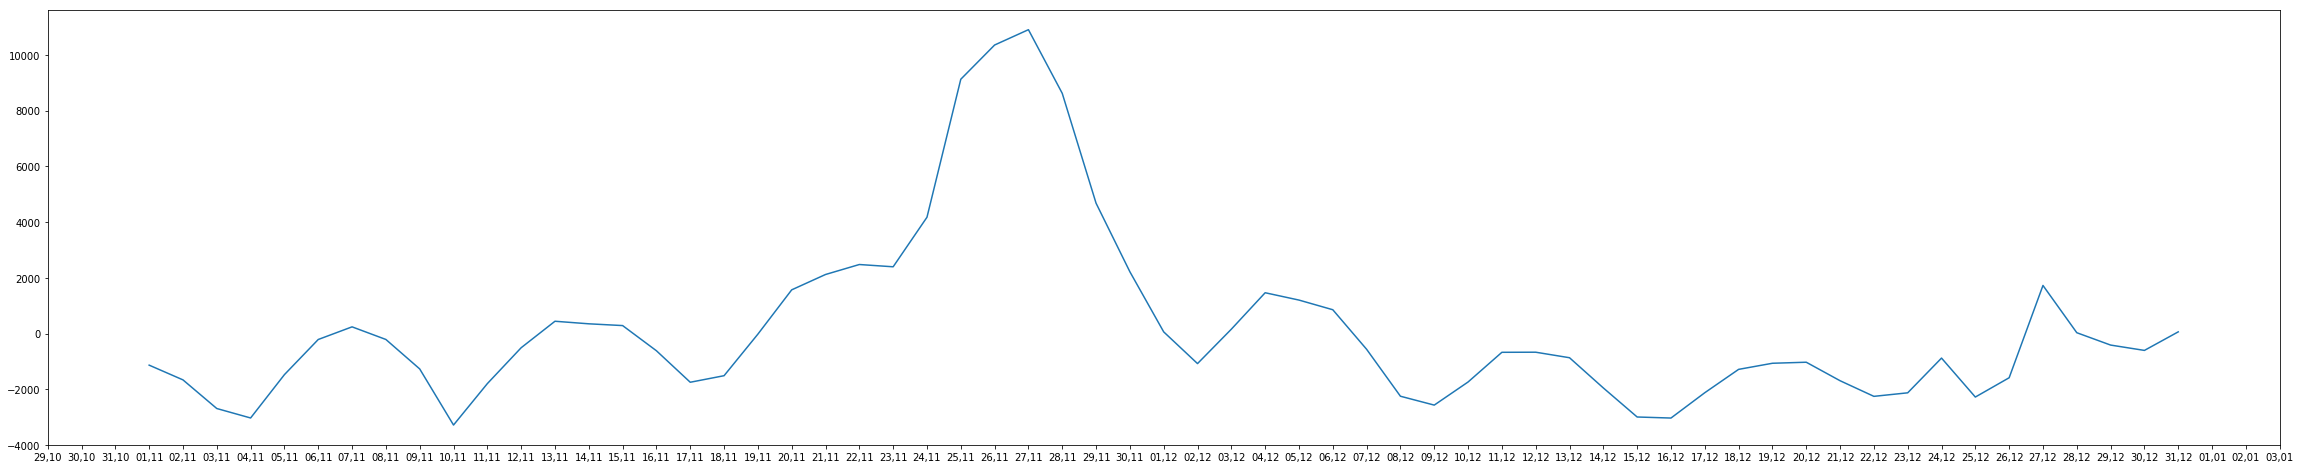

In [476]:
startdate = pd.to_datetime("2015-11-01").date()

enddate = pd.to_datetime("2015-12-31").date()

Nov_to_Dec = home_dp.loc[startdate : enddate]

dimensions = (40,8)
fig, ax = pyplot.subplots(figsize = dimensions)
months = mdates.MonthLocator()
days = mdates.DayLocator()
daymonth = mdates.DateFormatter('%d,%m')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daymonth)

ax.plot(Nov_to_Dec.index, Nov_to_Dec.seasonal)

Q2. What does the seasonality look like for home depot?
Is the seasonality driven by the product or consumers? 
Why do you think that is?
Answer: The seasonality look positive for home depot. There is definitely a pattern in the data even if we get rid of the spikes. The seasonality is driven by the consumers because consumers tend to attract more during holiday seasons when home depot offers sale on products. The products are not driving search interest here. It is evident from the fact that there is a trend in the end of May month which is due to Memorial day sales and particularly on days of July 4 and November 27, which are due to Independence day and Black friday sales. 

Plotting the residuals/ouliers monthly to closely observe the data.

The plot has constant mean and variance with few spikes upwards as well as downwards.

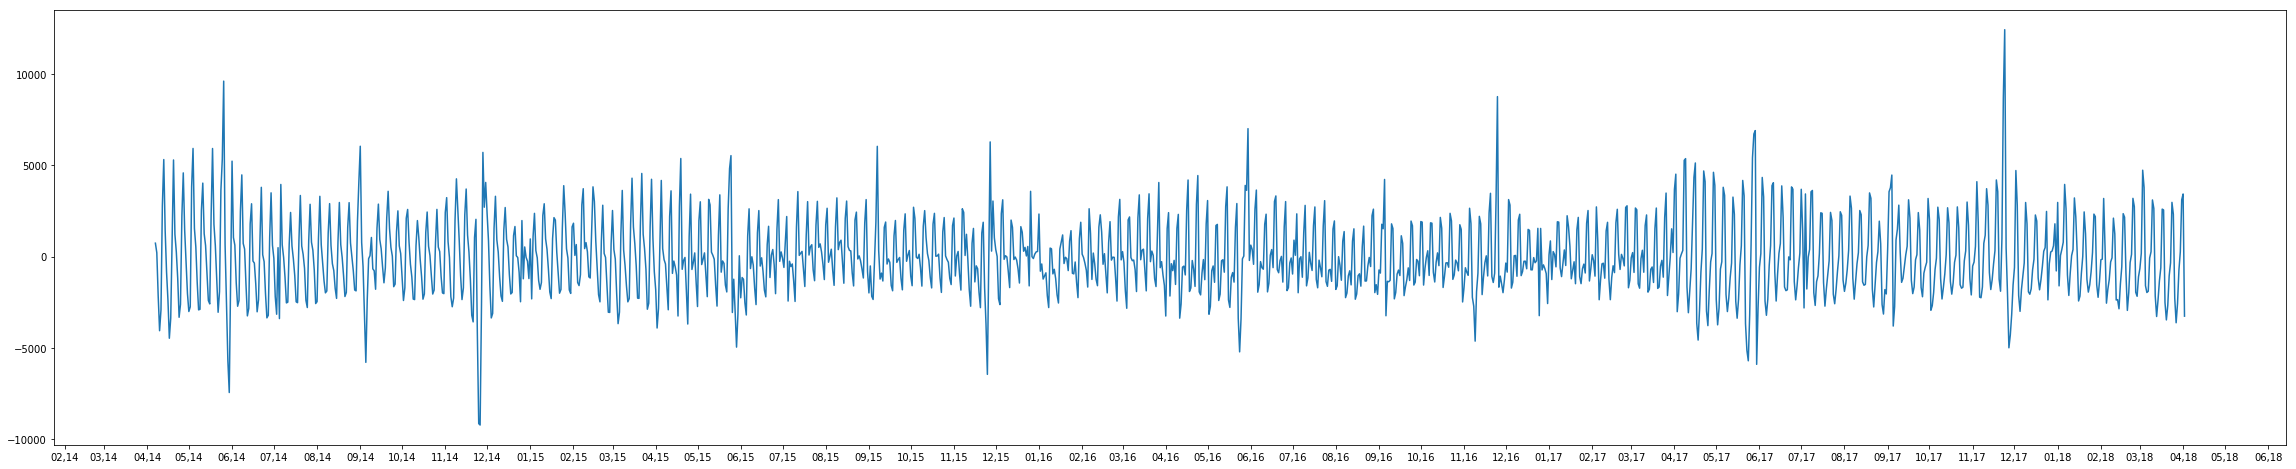

In [478]:
dimensions = (40,8)
fig, ax = pyplot.subplots(figsize=dimensions)

years = mdates.YearLocator()
months = mdates.MonthLocator()

yearmonth = mdates.DateFormatter('%m,%y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)

ax.plot(home_dp.index,decompose_model.resid)

# FACEBOOK'S PROPHET FORECASTING TOOL
Next I am creating a forecast for the next calendar year using facebook's prophet forecasting tool. 

Importing the above mentioned tool. 

In [479]:
from fbprophet import Prophet 

Looking at the data

In [480]:
home_dp.head()

,Unnamed: 0,date,value,onediffvalue,seasonal
period,,,,,
2013-10-07,0,Oct 07 2013,13131.555401,NaN,-2750.349013
2013-10-08,1,Oct 08 2013,12909.450492,-222.104909,-2047.359589
2013-10-09,2,Oct 09 2013,12590.684964,-318.765527,-999.005147
2013-10-10,3,Oct 10 2013,12300.446565,-290.238400,-561.772008
2013-10-11,4,Oct 11 2013,12599.330034,298.883469,-1035.479192


In [481]:
home_dp.reset_index(inplace=True)
home_dp.head()

,period,Unnamed: 0,date,value,onediffvalue,seasonal
0,2013-10-07,0,Oct 07 2013,13131.555401,NaN,-2750.349013
1,2013-10-08,1,Oct 08 2013,12909.450492,-222.104909,-2047.359589
2,2013-10-09,2,Oct 09 2013,12590.684964,-318.765527,-999.005147
3,2013-10-10,3,Oct 10 2013,12300.446565,-290.238400,-561.772008
4,2013-10-11,4,Oct 11 2013,12599.330034,298.883469,-1035.479192


Creating new blank dataframe 

In [482]:
prophetdataframe = pd.DataFrame()

Setting the parameters required for the analysis.
- Datastamp is located at 'ds' which is in period variable of data.
- The Time series data which is 'y' is in value column of data.

In [483]:
prophetdataframe['ds'] = home_dp['period']
prophetdataframe['y'] = home_dp['value']

In [484]:
prophetdataframe.head()

,ds,y
0,2013-10-07,13131.555401
1,2013-10-08,12909.450492
2,2013-10-09,12590.684964
3,2013-10-10,12300.446565
4,2013-10-11,12599.330034


In [485]:
m = Prophet()

In [486]:
m.fit(prophetdataframe)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting the next 365 days best estimates.
The dataframe is blank and doesn't have value stored until now. 

In [487]:
future = m.make_future_dataframe(periods=365) 

Ckecking the dates in dataframe 

In [488]:
future.tail()

,ds
2181,2019-09-27
2182,2019-09-28
2183,2019-09-29
2184,2019-09-30
2185,2019-10-01


Forecasting using predict function and checking the last rows of the data.
- The yhat represents the future predictive value for ds dates.
- yhat_lower and yhat_upper represents the confidence interval of 95%.

In [489]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2181,2019-09-27,19961.538168,14275.672713,18680.140029,19804.542012,20128.799259,-3531.396126,-3531.396126,-3531.396126,-995.222969,-995.222969,-995.222969,-2536.173157,-2536.173157,-2536.173157,0.0,0.0,0.0,16430.142043
2182,2019-09-28,19963.797795,18001.842920,22425.430088,19806.315889,20131.622232,169.923112,169.923112,169.923112,2740.018983,2740.018983,2740.018983,-2570.095871,-2570.095871,-2570.095871,0.0,0.0,0.0,20133.720907
2183,2019-09-29,19966.057422,18446.303172,22943.957161,19808.089766,20134.295571,819.016193,819.016193,819.016193,3398.205934,3398.205934,3398.205934,-2579.189741,-2579.189741,-2579.189741,0.0,0.0,0.0,20785.073615
2184,2019-09-30,19968.317048,14952.209716,19377.054347,19809.768937,20136.778291,-2809.150168,-2809.150168,-2809.150168,-245.102548,-245.102548,-245.102548,-2564.047620,-2564.047620,-2564.047620,0.0,0.0,0.0,17159.166880
2185,2019-10-01,19970.576675,13574.737649,17957.946674,19810.894671,20139.551383,-4074.495769,-4074.495769,-4074.495769,-1548.565048,-1548.565048,-1548.565048,-2525.930721,-2525.930721,-2525.930721,0.0,0.0,0.0,15896.080906


Plotting the above model.
-  The black dots in the plot are the observed values.
- the darkest blue is the error in the observation each day: the thickness represents the range of error.
- Our goal is to minimise the dark blue bar.
- Light blue represents the confidence interval of 95%.
- This model does not look very intuitive as it has many outliers.

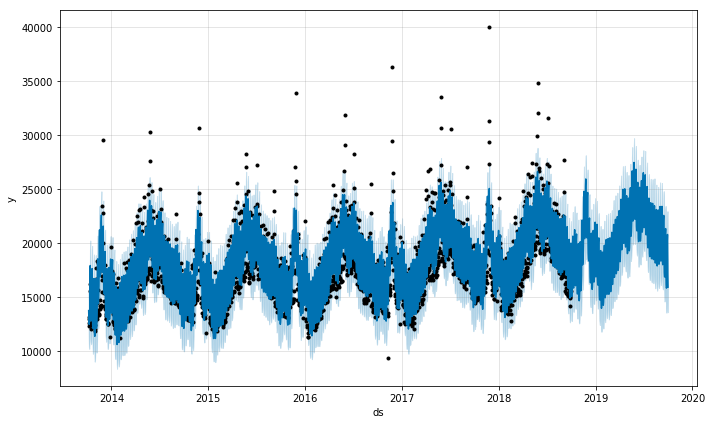

In [490]:
fig1 = m.plot(forecast)

Plotting the seasonality components.
1. Yearly trend: This trend line is almost same as the basic decomposed model and shows growth every year with a slight downfall between the years 2016 and 2017. The wing at the end represents future predicted average. It can be said that homedepot searches will grow in future but, due to lack of data and consisitency it cannot be said certainly.
2. Day of the week: It can be observed from the plot that weekdays have least searches compared to weekends. This graph is helpful to understand and conclude the days when home depot should spend more on adwords, such as Friday to Monday and most on Saturday and Sundays.
3. This is an yearly plot and shows the average searches in all months. 

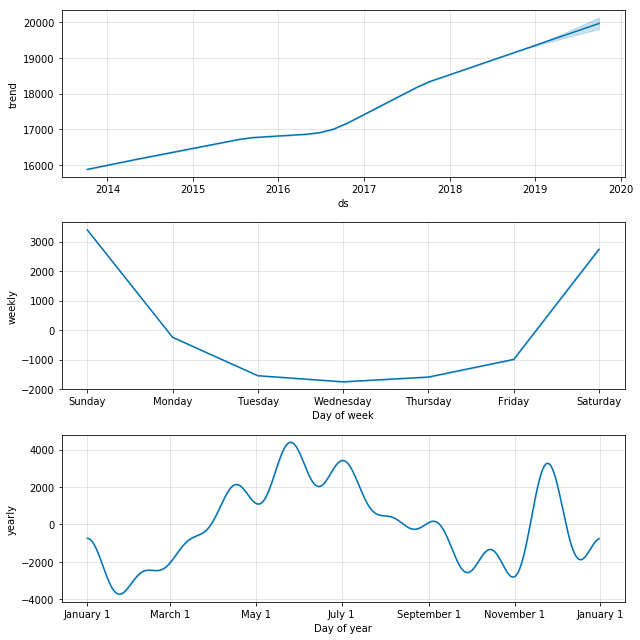

In [491]:
fig2 = m.plot_components(forecast)

Error Analysis 

In [492]:
erroranalysis = m.predict(prophetdataframe)

This code will give the predictive value for each day and also the actual observed value.

In [493]:
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']


Getting the absolute values of the residuals and observing the result of intial rows. 

- yhat represents the expected residuals.
- value represents the actual observations.
- residuals represents how much we were off by each day
- absoluteresiduals represents the absolute value of residuals.

For ex: 
In the first row the expected seraches were 13731 but actually  observed as 12955, which means we were off by 776 that particular day.


In [494]:
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

erroranalysis.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,value,residuals,absoluteresiduals
0,2013-10-07,15869.459150,11464.695494,15803.101077,15869.459150,15869.459150,-2144.852750,-2144.852750,-2144.852750,-245.102548,...,-1899.750202,-1899.750202,-1899.750202,0.0,0.0,0.0,13724.606400,13131.555401,-593.050999,593.050999
1,2013-10-08,15870.816962,10418.093042,14940.660615,15870.816962,15870.816962,-3332.173309,-3332.173309,-3332.173309,-1548.565048,...,-1783.608261,-1783.608261,-1783.608261,0.0,0.0,0.0,12538.643652,12909.450492,370.806839,370.806839
2,2013-10-09,15872.174773,10140.119526,14716.134314,15872.174773,15872.174773,-3429.098152,-3429.098152,-3429.098152,-1755.322485,...,-1673.775668,-1673.775668,-1673.775668,0.0,0.0,0.0,12443.076621,12590.684964,147.608344,147.608344
3,2013-10-10,15873.532585,10492.487990,14831.162079,15873.532585,15873.532585,-3168.240017,-3168.240017,-3168.240017,-1594.011868,...,-1574.228149,-1574.228149,-1574.228149,0.0,0.0,0.0,12705.292568,12300.446565,-404.846003,404.846003
4,2013-10-11,15874.890396,11076.137347,15592.542875,15874.890396,15874.890396,-2483.856579,-2483.856579,-2483.856579,-995.222969,...,-1488.633610,-1488.633610,-1488.633610,0.0,0.0,0.0,13391.033817,12599.330034,-791.703784,791.703784


Fetching the sum of error

In [495]:
totalerror = erroranalysis['absoluteresiduals'].sum()
print("In total we were off by:")
print(totalerror)

In total we were off by:
1818099.379479112


In [496]:
print("On average by day google trends is off by:")
print(totalerror/len(erroranalysis))

On average by day google trends is off by:
998.4071276656299


In [497]:
print("""This model is doing good, because the mean of error is 17215 with sd of 3555 and minimum of 9163.
The average error we received from our model is 998 which is significantly less than mean and minimum value and is within half sd""")

erroranalysis['value'].describe()



This model is doing good, because the mean of error is 17215 with sd of 3555 and minimum of 9163.
The average error we received from our model is 998 which is significantly less than mean and minimum value and is within half sd


count     1821.000000
mean     17211.059879
std       3555.563850
min       9283.395137
25%      14675.012858
50%      16654.049450
75%      18897.234107
max      40037.429003
Name: value, dtype: float64

Adding holidays to see what is happening around them.
Also considering the weekdays during holiday.


In [498]:
import holidays
from datetime import date

In [499]:
goodholidays = []
for date, name in sorted(holidays.US(years = 2014).items()):
    print(date, name)
    goodholidays.append(name)

2014-01-01 New Year's Day
2014-01-20 Martin Luther King, Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day


In [500]:
goodholidays.remove("New Year's Day")
goodholidays.remove("Martin Luther King, Jr. Day")
goodholidays.remove("Columbus Day")
goodholidays.remove("Veterans Day")

Creating a dataframe to save holidays, period and lower/upper window.
- Lower window represents the previous days to be counted in the holidays. For ex: if the holiday is on Monday, we would want to add Saturday and Sunday to the holiday season.
- Upper window represents the coming days to be counted in the holiday. For ex: if the holiday is on Friday, we would want to consider weekend also, thereby adding 2 days. 

In [501]:
sales = pd.DataFrame(columns=['holiday','ds','lower_window','upper_window'])
sales.head()


,holiday,ds,lower_window,upper_window


In [502]:
for year in range(2014, 2021):
    for date, name in sorted(holidays.US(years=year).items()):
        lower_window = 0
        upper_window = 0
        if name in goodholidays:
            dayoftheweek = date.weekday()
            if dayoftheweek == 0:
                lower_window = -2
            if dayoftheweek == 1:
                lower_window = -3
            if dayoftheweek == 3:
                upper_window = 3
            if dayoftheweek == 4:
                upper_window = 2
            sales.loc[len(sales)] = [name, date, lower_window, upper_window]

            
            
            

In [503]:
sales.head()


,holiday,ds,lower_window,upper_window
0,Washington's Birthday,2014-02-17,-2,0
1,Memorial Day,2014-05-26,-2,0
2,Independence Day,2014-07-04,0,2
3,Labor Day,2014-09-01,-2,0
4,Thanksgiving,2014-11-27,0,3


Saving the dataframe to csv and adding Black Friday in the data.

In [504]:
#sales.to_csv('sales.csv')

In [505]:
sales1 = pd.read_csv("sales.csv")

In [507]:
sales1.head(7)

,Unnamed: 0,holiday,ds,lower_window,upper_window
0,0,Washington's Birthday,2/17/14,-2,0
1,1,Memorial Day,5/26/14,-2,0
2,2,Independence Day,7/4/14,0,2
3,3,Labor Day,9/1/14,-2,0
4,4,Thanksgiving,11/27/14,0,3
5,5,Christmas Day,12/25/14,0,3
6,6,Black Friday,11/28/14,0,2


Running the prophet model again

In [508]:
prophetdataframe['ds'] = home_dp['period']
prophetdataframe['y'] = home_dp['value']
prophetdataframe.head()

,ds,y
0,2013-10-07,13131.555401
1,2013-10-08,12909.450492
2,2013-10-09,12590.684964
3,2013-10-10,12300.446565
4,2013-10-11,12599.330034


Loading the holidays in the data.

In [509]:
m = Prophet(holidays=sales1)

In [510]:
m.add_country_holidays(country_name='US')

In [511]:
m.fit(prophetdataframe)
print(m.train_holiday_names)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0           Washington's Birthday
1                    Memorial Day
2                Independence Day
3                       Labor Day
4                    Thanksgiving
5                   Christmas Day
6                    Black Friday
7                  New Year's Day
8     Martin Luther King, Jr. Day
9                    Columbus Day
10                   Veterans Day
11       Christmas Day (Observed)
12      New Year's Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
dtype: object


In [512]:
future = m.make_future_dataframe(periods=365) 
forecast = m.predict(future)

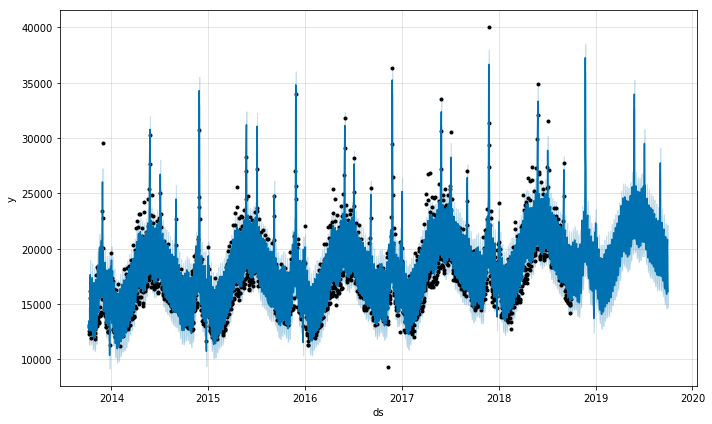

In [513]:
fig1 = m.plot(forecast)

# Detecting outlier events

Q1. Visually inspect outliers from your best time series analysis, that is, times where expected Google search interest was much lower than the result that occurred. Use Google News, or a similar search engine to see if news events (such as a breaking news story) drove that interest. Report back on why you think outliers occurred in your data. Put this outliers in a marketing context. What strategies can we derive from these outliers? If people were searching for your brand in a positive way, how can we adopt marketing strategies that would recreate similar positive events.

Answer: After inspecting the above time series model I found one outlier where the expected Google search interest was much lower than the result occurred. 

Nov 9, 2016: This outlier can be observed in fig1 forecast model above. On seraching via Google News I found that it was anticipated because Donald Trump won the election on Nov 8, 2016 and Trump's tariffs had raised the price of everything from clothing to power electronics/electricals. 

This outlier was anticipated as per the election results. The introduction of tariffs would raise the price of everything and understandably, leave business owners concerned. Such circumstances can be managed with establishing careful business plans. The strategies to deal with such outliers would include:

1. Wait and observe: Sometimes the new government make reforms in Laws as soon as they are elected but later modifies it as per successes and failure rates and also with the impact it has on economy and people. Therefore, there is no harm to wait for sometime before changing the business strategies. Instead, this time could be utilised in campaigning about the differences in pricing post tariff reform.  If chosen to take no action with regard to the business plans, the business would still benefit from an information campaign to educate your customers about how the change will impact them.

2. By Lowering the prices: For a business like Home Depot, success depends on volume, so every customer counts. Therefore, to maintain customer retention and acquisition, it has to reduce the prices of products. Some customers can be very price sensitive and even a small increase can cause them to try a competitor or substitute product. 

3. Adding value to offers/launching new schemes: For the products whose business revolves around quality, lowering prices might actually do much more harm. A value added approach might be right for such products. It can be anything like buy one and get a supplement free. This approach can balance out the loss from waiting and reducing the prices.


If people were searching the brand in positive way, the business should target the customers searching the brand more often with lucrative offers related to there past searches. The digital advertisements should be planned in a way that it reaches out to the people in every fixed days with suggestions.  







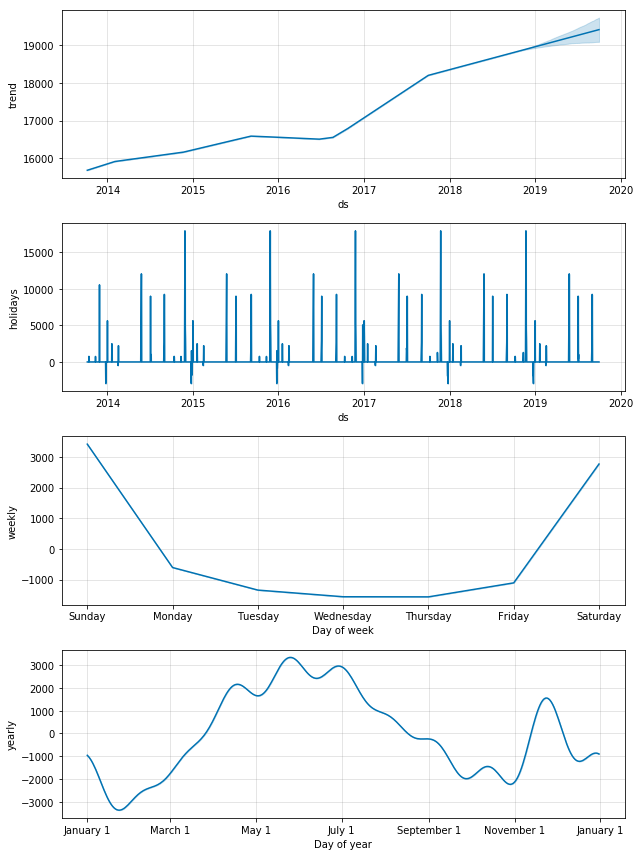

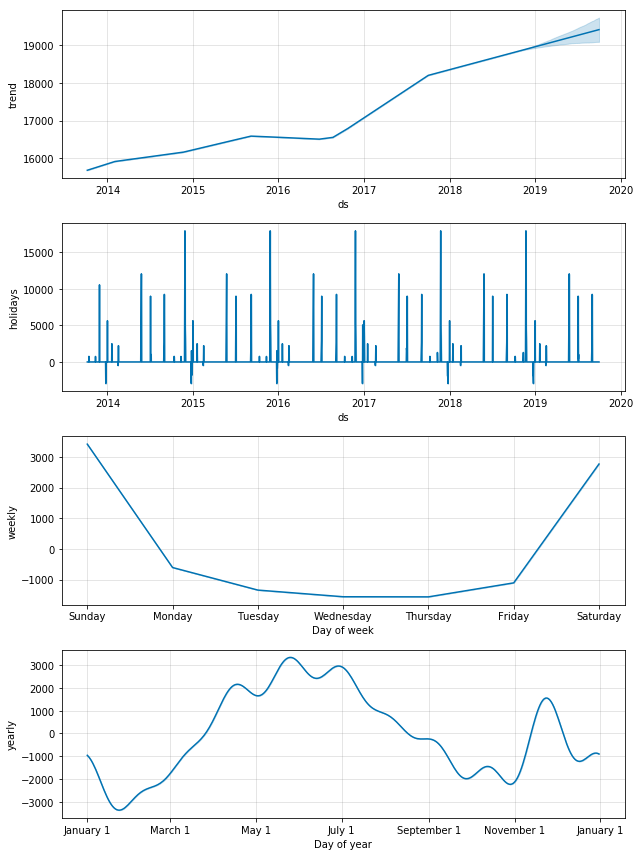

In [514]:
m.plot_components(forecast)

In [515]:
forecast.to_csv('forecast.csv')

In [516]:
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

In [517]:
totalerror = erroranalysis['absoluteresiduals'].sum()
print("In total google trends is off by:")
print(totalerror)
print("Which is less than the value observed in above model.")

In total google trends is off by:
1248930.9003524831
Which is less than the value observed in above model.


In [518]:
print("On average by day google trends is off by")
print(totalerror/len(erroranalysis))
print("Our model has improved by adding holiday component, as the figure has reduced from 998 to 693")



On average by day google trends is off by
685.848929353368
Our model has improved by adding holiday component, as the figure has reduced from 998 to 693


Printing n largest values for the absolute residuals column which represents absolute value of residuals.

On 29th Nov 2013, the expected number of observation were 15834 and actually observed were 29573 which means the data was off by 13738. Searching for the date online gives information that it was Black Friday and Home Depot had many lucrative offers on various products. 

Except for the above date, all other observations look consistent and within a range of 3500-5200.

In [519]:
print(erroranalysis.nlargest(10, 'absoluteresiduals'))

             ds         trend    yhat_lower    yhat_upper   trend_lower  \
53   2013-11-29  15784.965023  14608.875318  17205.010332  15784.965023   
1129 2016-11-09  16857.957518  13135.215196  15754.105459  16857.957518   
1182 2017-01-01  17076.334272  23820.252103  26479.908123  17076.334272   
1280 2017-04-09  17480.134776  21253.931855  23793.546486  17480.134776   
1175 2016-12-25  17047.491376  15347.053532  17855.136339  17047.491376   
635  2015-07-04  16493.639080  29688.231667  32419.384753  16493.639080   
1541 2017-12-26  18344.684834  14841.698156  17375.620954  18344.684834   
1287 2017-04-16  17508.977670  21711.310291  24265.062369  17508.977670   
1672 2018-05-06  18563.238327  22471.116578  24955.461875  18563.238327   
1507 2017-11-22  18287.961027  17000.483854  19586.775561  18287.961027   

       trend_upper  Black Friday  Black Friday_lower  Black Friday_upper  \
53    15784.965023           0.0                 0.0                 0.0   
1129  16857.957518    

Removing all the holidays except for Independence day, Labour day, Thanksgiving and Black Friday to observe the graph. The graph remains almost the same, which means that these are the holidays that captures most of the outliers.

In [520]:
goodholidays.remove("Washington's Birthday")
goodholidays.remove("Memorial Day")
goodholidays.remove("Christmas Day")

In [521]:
sales_new = pd.DataFrame(columns=['holiday','ds','lower_window','upper_window'])


In [522]:
for year in range(2014, 2021):
    for date, name in sorted(holidays.US(years=year).items()):
        lower_window = 0
        upper_window = 0
        if name in goodholidays:
            dayoftheweek = date.weekday()
            if dayoftheweek == 0: 
                lower_window = -2
            if dayoftheweek == 1:
                lower_window = -3
            if dayoftheweek == 3:
                upper_window = 3
            if dayoftheweek == 4:
                upper_window = 2
            sales_new.loc[len(sales_new)] = [name, date, lower_window, upper_window]

In [523]:
sales_new.head()

,holiday,ds,lower_window,upper_window
0,Independence Day,2014-07-04,0,2
1,Labor Day,2014-09-01,-2,0
2,Thanksgiving,2014-11-27,0,3
3,Independence Day,2015-07-04,0,0
4,Labor Day,2015-09-07,-2,0


In [524]:
#sales_new.to_csv('sales_new.csv')

In [525]:
sales_new = pd.read_csv("sales_new.csv")

In [526]:
m = Prophet(holidays=sales_new)
m.add_country_holidays(country_name='US')
m.fit(prophetdataframe)
print(m.train_holiday_names)
future = m.make_future_dataframe(periods=365) 
forecast = m.predict(future)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0                Independence Day
1                       Labor Day
2                    Thanksgiving
3                    Black Friday
4                  New Year's Day
5     Martin Luther King, Jr. Day
6           Washington's Birthday
7                    Memorial Day
8                    Columbus Day
9                    Veterans Day
10                  Christmas Day
11       Christmas Day (Observed)
12      New Year's Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
dtype: object


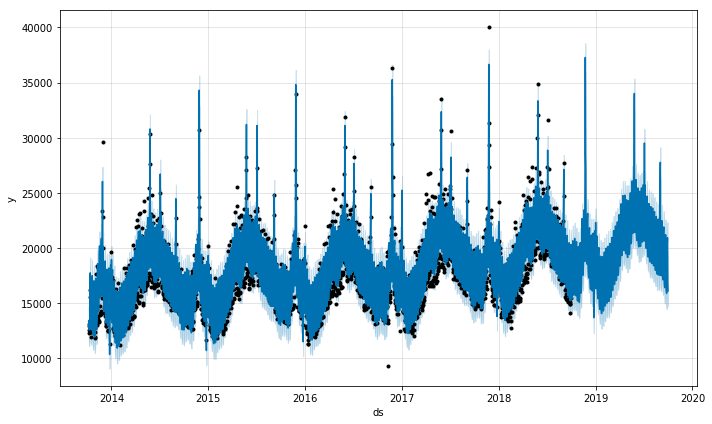

In [527]:
fig1 = m.plot(forecast)

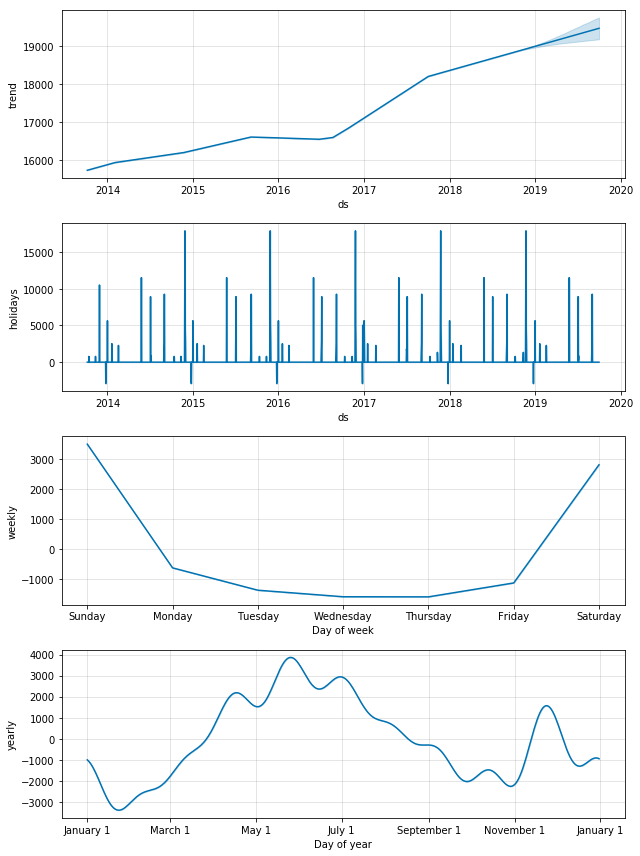

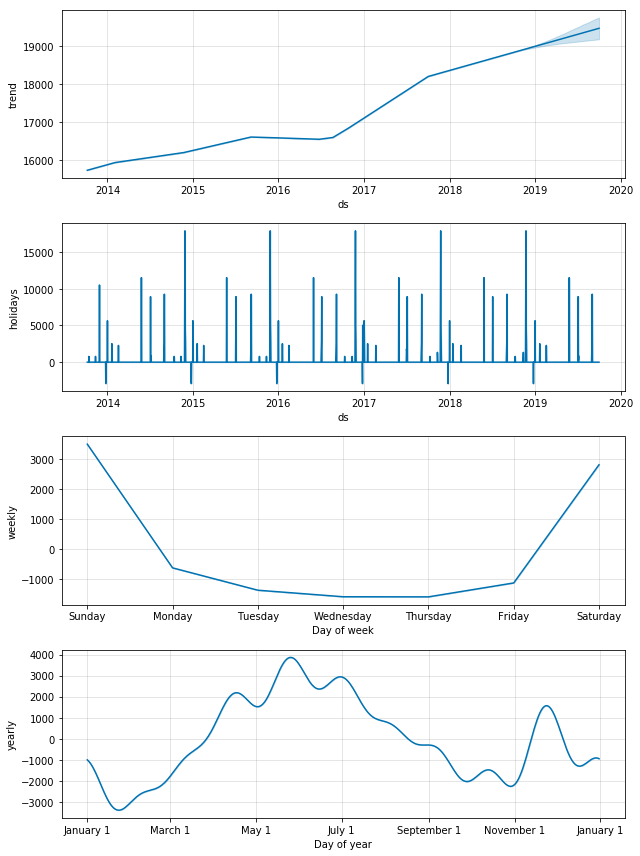

In [528]:
m.plot_components(forecast)

Q1. How accurate does the model appear to be? Are the residuals consistent across time? If not, why do you think it varies?
Answers: This model is more intuitive and has less errors on average. I am pretty confident that it is working fine.
Looking at the graph it can be observed that residuals are consistent across time. 

Q2. What are the projected high interest times"?
What are the projected low interest times?
Answers: From the visualization above, it is clear that the projected high interest times is the period of Thanksgiving and Black Friday as Home Depot offers the biggest sale of the year during this period. Similarly, it is clear that search interest reduces after Christmas and New Year's sale, as a result the period of January becomes low interest times. 

# AD SPEND DATA

Next, I have used the data exported by Dr. Vargo at the Univeristy of Colorado boulder for Home Depot. Before using the expenditure time series as predictors I have tested the stationarity of the data.

In [529]:
import matplotlib.pyplot as pyplot
from datetime import date 

In [530]:
adspend = pd.read_csv("home depot.adspend.csv")

In [531]:
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SYNDICATION DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"WEEK OF OCT 07, 2013 (B)",Home Depot Home Center & Kidde : Combo Vignette,6.3,0.0,0.0,0.0,6.3,0.0,0.0,0.0,0.0,0.0,0.0
1,"WEEK OF OCT 07, 2013 (B)",Home Depot Home Center : Home Center/Hardware ...,5128.7,1465.2,1211.8,171.9,348.3,0.0,0.0,238.2,1635.2,58.3,0.0
2,"WEEK OF OCT 07, 2013 (B)",Home Depot Home Center : Vignette,2.6,0.0,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"WEEK OF OCT 14, 2013 (B)",Home Depot Home Center & Kidde : Combo Vignette,6.1,0.0,0.0,0.0,6.1,0.0,0.0,0.0,0.0,0.0,0.0
4,"WEEK OF OCT 14, 2013 (B)",Home Depot Home Center : Home Center/Hardware ...,4760.4,1753.1,1105.8,91.1,116.9,0.0,0.0,0.0,1635.2,58.3,0.0


This data shows the money spent by Home depot on adverstisements.
This data has weeks in time period column and would cause an issue if merged with google trends data. 
The period column is cleaned using pivot table in pandas. 

In [532]:
adspend["TIME PERIOD"] = adspend["TIME PERIOD"].str.replace("WEEK OF", "", regex = True)
                                                            
                                                            

In [533]:
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SYNDICATION DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"OCT 07, 2013 (B)",Home Depot Home Center & Kidde : Combo Vignette,6.3,0.0,0.0,0.0,6.3,0.0,0.0,0.0,0.0,0.0,0.0
1,"OCT 07, 2013 (B)",Home Depot Home Center : Home Center/Hardware ...,5128.7,1465.2,1211.8,171.9,348.3,0.0,0.0,238.2,1635.2,58.3,0.0
2,"OCT 07, 2013 (B)",Home Depot Home Center : Vignette,2.6,0.0,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"OCT 14, 2013 (B)",Home Depot Home Center & Kidde : Combo Vignette,6.1,0.0,0.0,0.0,6.1,0.0,0.0,0.0,0.0,0.0,0.0
4,"OCT 14, 2013 (B)",Home Depot Home Center : Home Center/Hardware ...,4760.4,1753.1,1105.8,91.1,116.9,0.0,0.0,0.0,1635.2,58.3,0.0


In [534]:
adspend["TIME PERIOD"] = adspend["TIME PERIOD"].str.replace(" \(B\)", "", regex = True)


In [535]:
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SYNDICATION DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"OCT 07, 2013",Home Depot Home Center & Kidde : Combo Vignette,6.3,0.0,0.0,0.0,6.3,0.0,0.0,0.0,0.0,0.0,0.0
1,"OCT 07, 2013",Home Depot Home Center : Home Center/Hardware ...,5128.7,1465.2,1211.8,171.9,348.3,0.0,0.0,238.2,1635.2,58.3,0.0
2,"OCT 07, 2013",Home Depot Home Center : Vignette,2.6,0.0,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"OCT 14, 2013",Home Depot Home Center & Kidde : Combo Vignette,6.1,0.0,0.0,0.0,6.1,0.0,0.0,0.0,0.0,0.0,0.0
4,"OCT 14, 2013",Home Depot Home Center : Home Center/Hardware ...,4760.4,1753.1,1105.8,91.1,116.9,0.0,0.0,0.0,1635.2,58.3,0.0


The column titles have (000) representing values in thousands is not required. 

In [536]:
adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "", regex = True)

In [537]:
print("Following are the column names in the cleaned data")
list(adspend)

Following are the column names in the cleaned data


['TIME PERIOD',
 'PRODUCT',
 'TOTAL',
 'NETWORK TV',
 'CABLE TV',
 'SYNDICATION',
 'SPOT TV',
 'MAGAZINES',
 'NATL NEWSP',
 'NEWSPAPER',
 'NETWORK RADIO',
 'NAT SPOT RADIO',
 'OUTDOOR']

We need a period column in date time format for analysis.

In [538]:
adspend["FIXED TIME"] = pd.to_datetime(adspend["TIME PERIOD"])

In [539]:
adspend.tail()

,TIME PERIOD,PRODUCT,TOTAL,NETWORK TV,CABLE TV,SYNDICATION,SPOT TV,MAGAZINES,NATL NEWSP,NEWSPAPER,NETWORK RADIO,NAT SPOT RADIO,OUTDOOR,FIXED TIME
751,"SEP 17, 2018",Home Depot Home Center : Home Center/Hardware ...,4273.8,1581.6,1622.9,4.2,2.9,0.0,0.0,0.3,1004.9,57.1,0.0,2018-09-17
752,"SEP 17, 2018",Home Depot Home Center : Vignette,5.5,0.0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-09-17
753,"SEP 24, 2018",Home Depot Home Center : Home Center/Hardware ...,3306.0,1814.8,423.1,4.2,1.7,0.0,0.0,0.3,1004.9,57.1,0.0,2018-09-24
754,"OCT 01, 2018",Home Depot Home Center : Home Center/Hardware ...,7212.0,1498.7,2411.7,4.2,37.2,2317.4,0.0,96.0,703.4,106.2,37.2,2018-10-01
755,"OCT 01, 2018",Home Depot Home Center : Vignette,7.7,0.0,7.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-10-01


The data has weekly values and not day wise, also that the weeks are repeating. Therefore, summing all the weekly spends on adds foranalysis.

In [540]:
adspendnoproducts = adspend.pivot_table(index = "FIXED TIME", aggfunc = np.sum)


In [541]:
list(adspendnoproducts)

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK RADIO',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'SYNDICATION',
 'TOTAL']

In [542]:
adspendnoproducts.index

DatetimeIndex(['2013-10-07', '2013-10-14', '2013-10-21', '2013-10-28',
               '2013-11-04', '2013-11-11', '2013-11-18', '2013-11-25',
               '2013-12-02', '2013-12-09',
               ...
               '2018-07-30', '2018-08-06', '2018-08-13', '2018-08-20',
               '2018-08-27', '2018-09-03', '2018-09-10', '2018-09-17',
               '2018-09-24', '2018-10-01'],
              dtype='datetime64[ns]', name='FIXED TIME', length=261, freq=None)

Creating plots for all the variables for visual analysis. 
It can be observed that there is regular expenditure in Cable tv, Newspaper and of course in Total, but also spikes in Magazines, NAT SPOT RADIO, Network radio and network tv. 

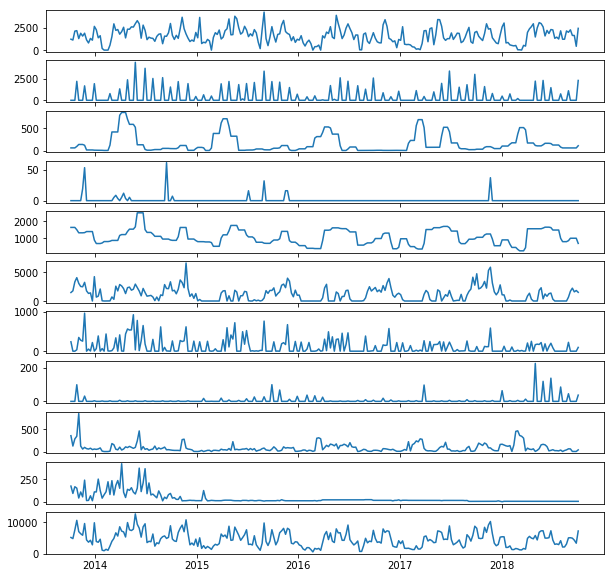

In [543]:
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = pyplot.subplots(11, figsize = dimensions, sharex = "all")

ax1.plot(adspendnoproducts.index, adspendnoproducts["CABLE TV"])
ax2.plot(adspendnoproducts.index, adspendnoproducts["MAGAZINES"])
ax3.plot(adspendnoproducts.index, adspendnoproducts["NAT SPOT RADIO"])
ax4.plot(adspendnoproducts.index, adspendnoproducts["NATL NEWSP"])
ax5.plot(adspendnoproducts.index, adspendnoproducts["NETWORK RADIO"])
ax6.plot(adspendnoproducts.index, adspendnoproducts["NETWORK TV"])
ax7.plot(adspendnoproducts.index, adspendnoproducts["NEWSPAPER"])
ax8.plot(adspendnoproducts.index, adspendnoproducts["OUTDOOR"])
ax9.plot(adspendnoproducts.index, adspendnoproducts["SPOT TV"])
ax10.plot(adspendnoproducts.index, adspendnoproducts["SYNDICATION"])
ax11.plot(adspendnoproducts.index, adspendnoproducts["TOTAL"])

Testing which day the week starts.

In [544]:
testdate = pd.to_datetime("2013-10-07")

In [555]:
print("The week starts on Monday which is denoted by %s" % testdate.weekday())


The week starts on Monday which is denoted by 0


Matching index in both the data. 

In [546]:
home_dp["period"] = pd.to_datetime(home_dp["period"])

In [547]:
home_dp.set_index("period", inplace = True)

In [548]:
home_dp.head()

,Unnamed: 0,date,value,onediffvalue,seasonal
period,,,,,
2013-10-07,0,Oct 07 2013,13131.555401,NaN,-2750.349013
2013-10-08,1,Oct 08 2013,12909.450492,-222.104909,-2047.359589
2013-10-09,2,Oct 09 2013,12590.684964,-318.765527,-999.005147
2013-10-10,3,Oct 10 2013,12300.446565,-290.238400,-561.772008
2013-10-11,4,Oct 11 2013,12599.330034,298.883469,-1035.479192


The ad spend data is distributed weekly whereas the home depot data is distributed day wise. Therefore, I have converted the home depot data into weekly format. 

In [549]:
home_dp_weekly = home_dp.resample('W-MON', closed = "left", label = "left").mean()


In [550]:
home_dp_weekly.head()

,Unnamed: 0,value,onediffvalue,seasonal
period,,,,
2013-10-07,3,13612.343729,506.833018,-1656.349770
2013-10-14,10,13627.097557,21.984022,-1962.294441
2013-10-21,17,13725.288088,-69.727032,-2170.678895
2013-10-28,24,13804.505975,258.580367,-2111.909542
2013-11-04,31,14862.841399,71.710993,-1314.890772


The dataframes are ready to be merged for further analysis.

In [551]:
mergedweeklydata = adspendnoproducts.join(home_dp_weekly)

In [552]:
mergedweeklydata.tail()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SYNDICATION,TOTAL,Unnamed: 0,value,onediffvalue,seasonal
FIXED TIME,,,,,,,,,,,,,,,
2018-09-03,2258.1,0.0,57.1,0.0,1004.9,1676.5,0.3,0.0,59.1,4.2,5060.2,1795,19012.581995,-775.669841,1218.333010
2018-09-10,1635.0,0.0,57.1,0.0,1004.9,2217.4,0.3,0.0,2.4,4.2,4921.2,1802,16799.847143,-97.780437,-1338.064919
2018-09-17,1628.4,0.0,57.1,0.0,1004.9,1581.6,0.3,0.0,2.9,4.2,4279.3,1809,16574.088218,98.136075,-1601.198599
2018-09-24,423.1,0.0,57.1,0.0,1004.9,1814.8,0.3,0.0,1.7,4.2,3306.0,1816,16168.333482,-43.637280,-1917.665694
2018-10-01,2419.4,2317.4,106.2,0.0,703.4,1498.7,96.0,37.2,37.2,4.2,7219.7,1820,15495.455187,-3515.060169,-575.340910


Plotting the total column from adspend data and value from home depot google trends data and checking if there is any correlation between the two.

We definitely don't see quite a correlation here through graphs.

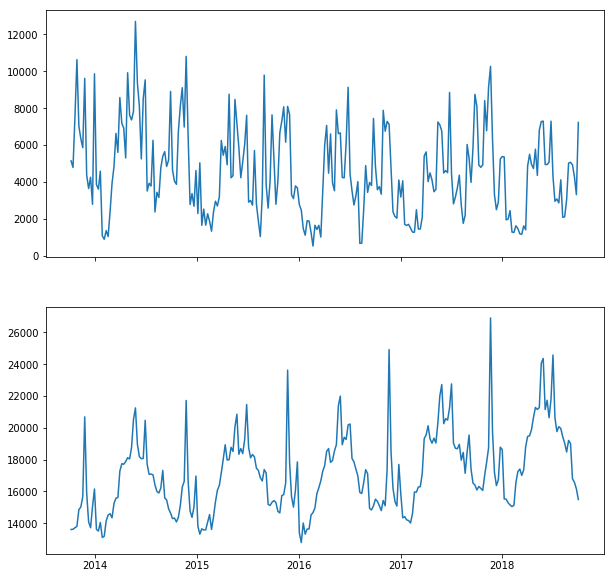

In [553]:
dimensions = (10, 10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex = "all")

ax1.plot(mergedweeklydata.index, mergedweeklydata["TOTAL"])
ax2.plot(mergedweeklydata.index, mergedweeklydata["value"])

Finding the correlation.

The columns are correlated but at a very small level.

In [554]:
print("The correlation between Total and Value is %s" % mergedweeklydata["TOTAL"].corr(mergedweeklydata["value"]))




The correlation between Total and Value is 0.4188833624615075


Adding "time difference" column and "value difference"

In [556]:
mergedweeklydata["Valuediff"] = mergedweeklydata["value"].diff(1)
mergedweeklydata["TOTALdiff"] = mergedweeklydata["TOTAL"].diff(1)

In [557]:
mergedweeklydata.head()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SYNDICATION,TOTAL,Unnamed: 0,value,onediffvalue,seasonal,Valuediff,TOTALdiff
FIXED TIME,,,,,,,,,,,,,,,,,
2013-10-07,1214.4,0.0,58.3,0.0,1635.2,1465.2,238.2,0.0,354.6,171.9,5137.6,3,13612.343729,506.833018,-1656.349770,NaN,NaN
2013-10-14,1119.7,0.0,58.3,0.0,1635.2,1753.1,0.0,0.0,123.0,91.1,4780.4,10,13627.097557,21.984022,-1962.294441,14.753828,-357.2
2013-10-21,2110.3,0.0,58.3,0.0,1635.2,3304.3,0.0,0.0,282.8,164.9,7555.8,17,13725.288088,-69.727032,-2170.678895,98.190531,2775.4
2013-10-28,2163.0,2216.8,91.0,0.0,1500.4,4027.4,36.4,99.0,342.6,149.3,10625.9,24,13804.505975,258.580367,-2111.909542,79.217887,3070.1
2013-11-04,1281.1,0.0,134.7,0.0,1320.7,3044.9,348.0,0.0,850.4,40.7,7020.5,31,14862.841399,71.710993,-1314.890772,1058.335424,-3605.4


In [559]:
print("The correlation between Totaldiff and Valuediff is %s" % mergedweeklydata["TOTALdiff"].corr(mergedweeklydata["Valuediff"]))
      
      

The correlation between Totaldiff and Valuediff is 0.395438156999404


Saving this data to csv

In [560]:
mergedweeklydata.to_csv("adspend.googletrends.weekly.csv")

Loading the above csv as dataframe.

In [561]:
adspend_trends = pd.read_csv("adspend.googletrends.weekly.csv", parse_dates = ["FIXED TIME"])


In [562]:
adspend_trends.set_index("FIXED TIME", inplace = True)

In [563]:
list(adspend_trends)

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK RADIO',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'SYNDICATION',
 'TOTAL',
 'Unnamed: 0',
 'value',
 'onediffvalue',
 'seasonal',
 'Valuediff',
 'TOTALdiff']

Dropping unnecessary columns.

In [564]:
adspend_trends = adspend_trends.drop(columns = ['Unnamed: 0','TOTALdiff','Valuediff', 'onediffvalue', 'seasonal'])



In [565]:
list(adspend_trends)

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK RADIO',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'SYNDICATION',
 'TOTAL',
 'value']

Running adf test to check whether the data is stationary or not.

The data seems to be stationary as the significant value is less than 0.05.

In [566]:
for acolumn in list(adspend_trends) : 
    adf_result = stattools.adfuller(adspend_trends[acolumn])
    print(adf_result[1])
    

3.3791311853282996e-07
0.0038259672408279596
0.0002320021957422997
8.791905734406244e-27
2.9987409119721522e-05
1.8113876761771767e-05
2.457816070789469e-14
0.013739831125602857
2.24411160183475e-14
0.2594174143129171
0.00011707969794838592
0.0019306128870273556


In [567]:
adspend_trends_diff = pd.DataFrame()

In [568]:
for acolumn in list(adspend_trends):
    columnname = "%s_diff" % (acolumn)
    adspend_trends_diff[columnname] = adspend_trends[acolumn].diff(1)

In [569]:
adspend_trends_diff.head()

,CABLE TV_diff,MAGAZINES_diff,NAT SPOT RADIO_diff,NATL NEWSP_diff,NETWORK RADIO_diff,NETWORK TV_diff,NEWSPAPER_diff,OUTDOOR_diff,SPOT TV_diff,SYNDICATION_diff,TOTAL_diff,value_diff
FIXED TIME,,,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,-94.7,0.0,0.0,0.0,0.0,287.9,-238.2,0.0,-231.6,-80.8,-357.2,14.753828
2013-10-21,990.6,0.0,0.0,0.0,0.0,1551.2,0.0,0.0,159.8,73.8,2775.4,98.190531
2013-10-28,52.7,2216.8,32.7,0.0,-134.8,723.1,36.4,99.0,59.8,-15.6,3070.1,79.217887
2013-11-04,-881.9,-2216.8,43.7,0.0,-179.7,-982.5,311.6,-99.0,507.8,-108.6,-3605.4,1058.335424


Slicing the data as the first row is NAn.

The adspend trends diff is very stationary as it is much less than 0.05.

In [570]:
for acolumn in list(adspend_trends_diff): 
    adf_result = stattools.adfuller(adspend_trends_diff[acolumn].iloc[1:])
    print(adf_result[1])

8.931658306987923e-09
2.3251608233122e-08
1.71711103106308e-08
2.7974092001278e-13
1.4440370944094597e-10
2.1707449759554387e-08
1.119373827228876e-07
2.7093253944695553e-08
4.5371810634902124e-12
0.0015808035613558496
3.248534799667198e-12
4.632283894376681e-12


Checking the columns which are correlated.

In [571]:
correlationlist = []
for acolumn in list(adspend_trends_diff):
    if "value" not in acolumn:
        corr = adspend_trends_diff[acolumn].corr(adspend_trends_diff["value_diff"])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV_diff 0.13937715447273719
MAGAZINES_diff 0.16856525374111098
NAT SPOT RADIO_diff 0.08264395412691886
NATL NEWSP_diff 0.30975307931870033
NETWORK RADIO_diff 0.17464078766138816
NETWORK TV_diff 0.3858127828679659
NEWSPAPER_diff 0.294336173731075
OUTDOOR_diff 0.08648001361257987
SPOT TV_diff 0.024945636192189615
SYNDICATION_diff 0.09606041787895395
TOTAL_diff 0.3954381569994042


In [572]:
print("The data is fairly correlated")
np.mean(correlationlist)


The data is fairly correlated


0.19618667369118398

Checking the columns which are correlated with the normal data without diff column.

In [573]:
correlationlist = []
for acolumn in list(adspend_trends):
    if "value" not in acolumn:
        corr = adspend_trends[acolumn].corr(adspend_trends["value"])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV 0.40407445789621704
MAGAZINES 0.17170950386279107
NAT SPOT RADIO 0.198417493736353
NATL NEWSP 0.12042522621764087
NETWORK RADIO 0.5314910197676347
NETWORK TV 0.15334023160202137
NEWSPAPER 0.3040851311445465
OUTDOOR 0.15381975191585215
SPOT TV 0.020777829352633753
SYNDICATION -0.11557584604585075
TOTAL 0.4188833624615077


The unstationary data is perfoming better. Maybe the data was already stationary as the significance value was much less than 0.05.

In [574]:
np.mean(correlationlist)

0.21467710562830436

Although the differenced data is much stationary, but for my analysis I have used normal data as it also performed stationary.

Creating a heatmap that will run a correlation matrix.

Cable tv, Magazines, Network Radio, Network tv and Newspaper are highly correlated with Total in the matrix which implies that most of the Total advertisement expenditure is composed of them.

Also Network Radio is correlated with Value(Count of google search interest). It can be interpreted as when people here about the sales and offers offered by Home Depot on Network Radio, they tend to serach more.

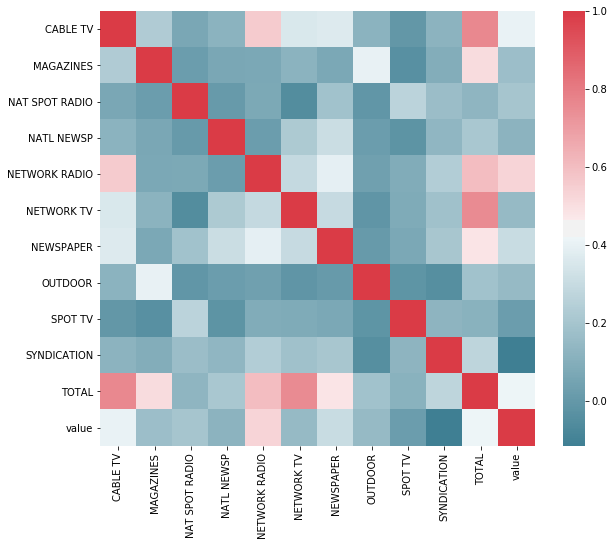

In [437]:
f, ax = pyplot.subplots(figsize =(10,8))
corr = adspend_trends.corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap =sns.diverging_palette(220, 10, as_cmap = True),
           square = True, ax = ax)

Testing granger causality now. 
As per the lag concept it is believed that the advertisement expenditure of a day/week will produce result/google searches until certain following days/weeks. Here, I have tested 8 weeks from the advertisement expenditure week. The test produces significant no of weeks for every varaible. 

In [438]:
numofweeks = 8
significantlags = []
for acolumn in list(adspend_trends):
    if 'value' not in acolumn:
        testframe = adspend_trends[["value", acolumn]]
        testframe = testframe.iloc[1:]
        results = stattools.grangercausalitytests(testframe, numofweeks, verbose = False )
        for week in range(1, numofweeks + 1):
            if results[week][0]['params_ftest'][1] < 0.05:
                print('%s is significant at %s weeks' % (acolumn, week))
                significantlags.append(week)
                

CABLE TV is significant at 1 weeks
CABLE TV is significant at 2 weeks
CABLE TV is significant at 3 weeks
CABLE TV is significant at 4 weeks
CABLE TV is significant at 5 weeks
CABLE TV is significant at 6 weeks
CABLE TV is significant at 7 weeks
CABLE TV is significant at 8 weeks
MAGAZINES is significant at 1 weeks
MAGAZINES is significant at 2 weeks
MAGAZINES is significant at 3 weeks
MAGAZINES is significant at 4 weeks
MAGAZINES is significant at 5 weeks
MAGAZINES is significant at 6 weeks
MAGAZINES is significant at 7 weeks
MAGAZINES is significant at 8 weeks
NAT SPOT RADIO is significant at 1 weeks
NAT SPOT RADIO is significant at 2 weeks
NAT SPOT RADIO is significant at 3 weeks
NAT SPOT RADIO is significant at 4 weeks
NAT SPOT RADIO is significant at 5 weeks
NAT SPOT RADIO is significant at 6 weeks
NAT SPOT RADIO is significant at 7 weeks
NAT SPOT RADIO is significant at 8 weeks
NATL NEWSP is significant at 1 weeks
NATL NEWSP is significant at 2 weeks
NATL NEWSP is significant at 3

In [440]:
mode(significantlags)
print("The mode of significant lags is %s" % mode(significantlags))


The mode of significant lags is 3


In [441]:
modelingdataset = adspend_trends

In [442]:
modelingdataset.tail()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SYNDICATION,TOTAL,value
FIXED TIME,,,,,,,,,,,,
2018-09-03,2258.1,0.0,57.1,0.0,1004.9,1676.5,0.3,0.0,59.1,4.2,5060.2,19012.581995
2018-09-10,1635.0,0.0,57.1,0.0,1004.9,2217.4,0.3,0.0,2.4,4.2,4921.2,16799.847143
2018-09-17,1628.4,0.0,57.1,0.0,1004.9,1581.6,0.3,0.0,2.9,4.2,4279.3,16574.088218
2018-09-24,423.1,0.0,57.1,0.0,1004.9,1814.8,0.3,0.0,1.7,4.2,3306.0,16168.333482
2018-10-01,2419.4,2317.4,106.2,0.0,703.4,1498.7,96.0,37.2,37.2,4.2,7219.7,15495.455187


In [444]:
date = pd.to_datetime('2018-10-08')
modelingdataset.loc[date] = np.nan

In [445]:
date = pd.to_datetime('2018-10-15')
modelingdataset.loc[date] = np.nan

In [446]:
date = pd.to_datetime('2018-10-22')
modelingdataset.loc[date] = np.nan

In [447]:
for acolumn in list(modelingdataset):
    if 'value' not in acolumn:
        for alag in range(1,4):
            columnname = '%s_lag%s' % (acolumn,alag)
            modelingdataset[columnname] = modelingdataset[acolumn].shift(alag)


In [448]:
modelingdataset.sort_index(axis=1, inplace=True)
modelingdataset.head()

,CABLE TV,CABLE TV_lag1,CABLE TV_lag1_lag1,CABLE TV_lag1_lag2,CABLE TV_lag1_lag3,CABLE TV_lag2,CABLE TV_lag2_lag1,CABLE TV_lag2_lag2,CABLE TV_lag2_lag3,CABLE TV_lag3,...,TOTAL_lag1_lag3,TOTAL_lag2,TOTAL_lag2_lag1,TOTAL_lag2_lag2,TOTAL_lag2_lag3,TOTAL_lag3,TOTAL_lag3_lag1,TOTAL_lag3_lag2,TOTAL_lag3_lag3,value
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2013-10-07,1214.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13612.343729
2013-10-14,1119.7,1214.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13627.097557
2013-10-21,2110.3,1119.7,1214.4,NaN,NaN,1214.4,NaN,NaN,NaN,NaN,...,NaN,5137.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13725.288088
2013-10-28,2163.0,2110.3,1119.7,1214.4,NaN,1119.7,1214.4,NaN,NaN,1214.4,...,NaN,4780.4,5137.6,NaN,NaN,5137.6,NaN,NaN,NaN,13804.505975
2013-11-04,1281.1,2163.0,2110.3,1119.7,1214.4,2110.3,1119.7,1214.4,NaN,1119.7,...,5137.6,7555.8,4780.4,5137.6,NaN,4780.4,5137.6,NaN,NaN,14862.841399


Saving this model to csv for running predictive model. 

In [449]:
modelingdataset.to_csv('google_adspend_fordatarobot.csv')



In [450]:
alldata = pd.read_csv("google_adspend_fordatarobot.csv")


In [451]:
alldata.set_index(alldata['FIXED TIME'], inplace=True)

In [452]:
list(alldata)

['FIXED TIME',
 'CABLE TV',
 'CABLE TV_lag1',
 'CABLE TV_lag1_lag1',
 'CABLE TV_lag1_lag2',
 'CABLE TV_lag1_lag3',
 'CABLE TV_lag2',
 'CABLE TV_lag2_lag1',
 'CABLE TV_lag2_lag2',
 'CABLE TV_lag2_lag3',
 'CABLE TV_lag3',
 'CABLE TV_lag3_lag1',
 'CABLE TV_lag3_lag2',
 'CABLE TV_lag3_lag3',
 'MAGAZINES',
 'MAGAZINES_lag1',
 'MAGAZINES_lag1_lag1',
 'MAGAZINES_lag1_lag2',
 'MAGAZINES_lag1_lag3',
 'MAGAZINES_lag2',
 'MAGAZINES_lag2_lag1',
 'MAGAZINES_lag2_lag2',
 'MAGAZINES_lag2_lag3',
 'MAGAZINES_lag3',
 'MAGAZINES_lag3_lag1',
 'MAGAZINES_lag3_lag2',
 'MAGAZINES_lag3_lag3',
 'NAT SPOT RADIO',
 'NAT SPOT RADIO_lag1',
 'NAT SPOT RADIO_lag1_lag1',
 'NAT SPOT RADIO_lag1_lag2',
 'NAT SPOT RADIO_lag1_lag3',
 'NAT SPOT RADIO_lag2',
 'NAT SPOT RADIO_lag2_lag1',
 'NAT SPOT RADIO_lag2_lag2',
 'NAT SPOT RADIO_lag2_lag3',
 'NAT SPOT RADIO_lag3',
 'NAT SPOT RADIO_lag3_lag1',
 'NAT SPOT RADIO_lag3_lag2',
 'NAT SPOT RADIO_lag3_lag3',
 'NATL NEWSP',
 'NATL NEWSP_lag1',
 'NATL NEWSP_lag1_lag1',
 'NATL NEWSP

# Used DataRobot for predictive modeling. 

Q1. Do any advertising expenditures drive Google search interest?
If so, which ones?
Why do you think that is?
If not, why do you think they fail to do so.

Answer: As per the correlation heatmap created above, it can be observed that Network Radio is correlated with Value, which means that it drives google search interest. 
Also, from the "Light Gradient Boosting on ElasticNet Predictive model ran in Datarobot, the following advertisement expenditures drive Google search interest:
NEWSPAPER_lag1 - Newspaper advertisements take time to reach puplic, therefore it is with lag. People tend to search the company after reading about it in the newspaper.
NETWORK TV, NETWORK RADIO_lag3, NEWSPAPER, CABLE TV_lag2, NETWORK TV_lag3, NETWORK RADIO, SYNDICATION, NETWORK TV_lag2, NETWORK RADIO_lag2, TOTAL_lag1 with few more which are less impactful. The feature impact also included FIXED TIME(Month) and FIXED TIME (Day of Month) which means fixed time plays a significant role in predicting value of google search interest. 

The model was trained on 70% data and tested on 30%. 
The r square of testing data is : 0.6911
and RMSE is : 1327.8538
